# **Forward, Backward, and Autograd**

#### 학습목표
1. PyTorch를 이용한 forward propagation, backward propagation의 과정과 PyTorch autograd의 여러가지 기능을 이해한다.

**Context**
1. Forward Propagation
2. Back Propagation
3. MyTorch Autograd 구현
4. PyTorch Autograd 비교

## 1. Forward Propagation

>딥러닝 모델은 computational graph로 표현할 수 있으며, computational graph의 node는 텐서 혹은 텐서들의 operation을 나타낸다.


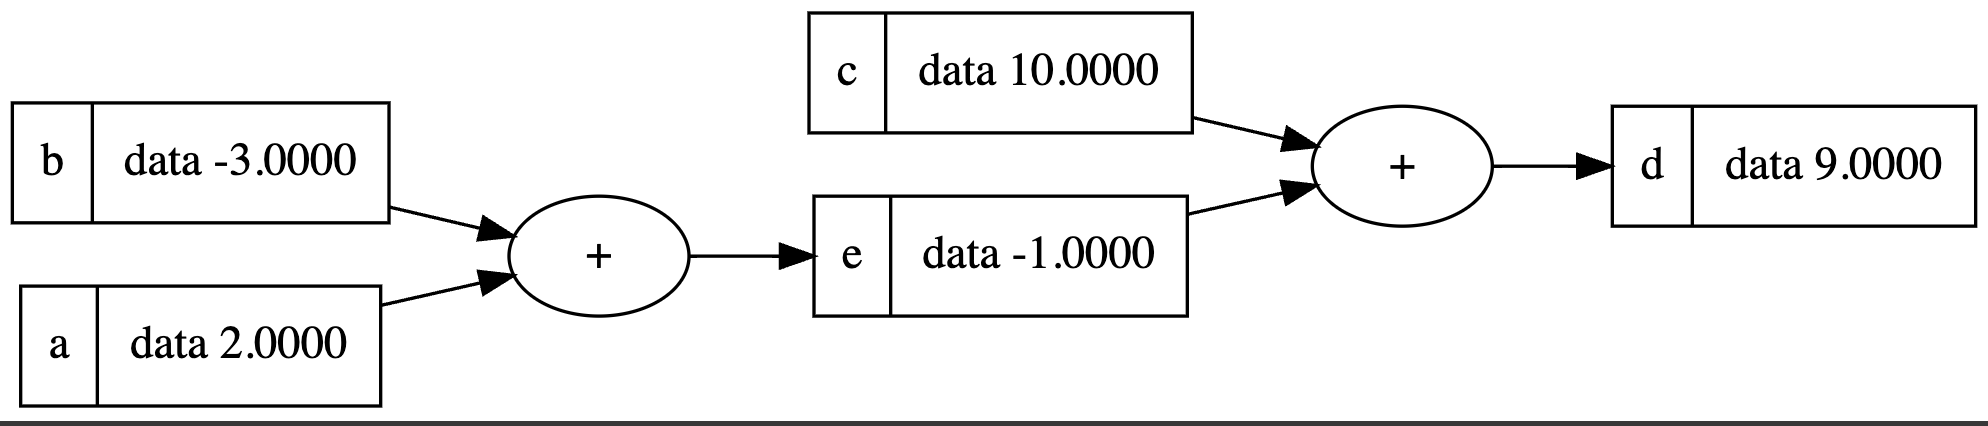

>Forward propagation (forward pass, 순전파) 은 입력값에 대해 정의된 computational graph에 따라 연산하여 최종 output을 도출하는 과정을 의미한다.
>
>딥러닝 모델(computational graph)은 일반적으로 여러 층(layer)이 있고, 각각의 layer에서 계산된 중간 값들이 다음 layer의 입력값으로 사용되는 순차적인 구조를 갖기 때문에 Forward **Propagation(전파)** 라고 부른다.


> 이번 실습에서는 PyTorch Tensor가 동작하는 원리를 자세히 알아보기 위해서 PyTorch Tensor를 직접 구현한다.
>
>실제 PyTorch source code는 매우 방대하고 복잡하기 때문에, 그 중에서 핵심적인 기능만을 고려한 toy library `MyTorch`의 `MyTensor` (텐서)를 구현한다.

In [ ]:
# 토이 텐서인 MyTensor 구현
# PyTorch와는 다르게 구현의 편의성을 위해 스칼라 값만 데이터로 받을 수 있다고 가정

class MyTensor:
    def __init__(self, data, _children=(), _op='', name=''):
        self.data = data
        self._prev = set(_children) # 해당 MyTensor instance의 children MyTensor 
        self._op = _op # 해당 MyTensor instance를 생성한 연산
        self.name = name

    def __repr__(self):
        return f"MyTensor({self.name}, data={self.data})"
    
    def __add__(self, other):
        out = MyTensor(self.data + other.data, (self, other), '+')
        return out
    
    def __mul__(self, other):
        out = MyTensor(self.data * other.data, (self, other), '*')
        return out

In [ ]:
a = MyTensor(2.0, name='a')
b = MyTensor(-3.0, name='b')
c = MyTensor(10.0, name='c')

# __add__, __mul__ python built-in magic method를 통해 다음과 같이 연산 가능
e = a+b; e.name='e'
d = e+c; d.name='d'

print(d)

MyTensor(d, data=9.0)


>d 의 children node 출력

In [ ]:
print(d._prev)

{MyTensor(e, data=-1.0), MyTensor(c, data=10.0)}


>d를 생성한 연산

In [ ]:
print(d._op)

+


>아래의 cell은 `graphviz`라는 라이브러리를 사용해서 MyTensor 연산의 compuational graph를 시각화하기 위한 코드이다.

In [ ]:
from graphviz import Digraph

# helper function
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

# helper function
def draw_dot(root, format='svg', rankdir='LR'):
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f }" % (n.name, n.data), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

>graphviz 라이브러리로 구현한 draw_dot 함수를 이용해 computational graph로 표현하면 다음과 같다.

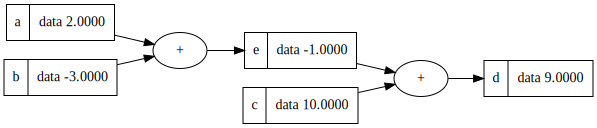

In [ ]:
draw_dot(d)

>조금 더 복잡한 computational graph를 정의하면 다음과 같이 표현된다.

In [ ]:
a = MyTensor(2.0, name='a')
b = MyTensor(-3.0, name='b')
c = MyTensor(10.0, name='c')
e = a+b; e.name='e'
d = e+c; d.name='d'
f = MyTensor(-2.0, name='f')
L = d*f; L.name='L'
print(L)

MyTensor(L, data=-18.0)


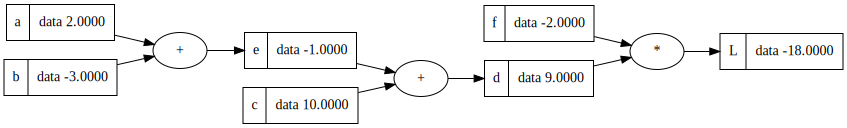

In [ ]:
draw_dot(L)

>일반적으로 graph에서 children node가 없는 말단의 node를 `leaf node`라고 부른다.
>
>마찬가지로, PyTorch에서도 이러한 node를 `leaf tensor`라고 부른다. 
>
>위 그래프를 예시로 들면, a, b, c, f가 leaf node에 해당한다.
>
>반면 e, d, L 은 다른 연산의 결과로서 생성되는 값을 data로 가지기 때문에(=chilren node가 있음) leaf node가 아니다.
>
>딥러닝 모델에서 leaf node는 입력 데이터 혹은 모델의 weight parameter에 해당한다.
>
>그 중에서 우리의 목적은 weight parameter를 조절해서 graph의 최종 output인 loss를 최대한 낮은 값으로 만드는 것이다.
>
>이를 위해서 backpropagation 및 gradient descent가 사용되는데, 우선 다음 장에서 backpropagation을 직접 구현한다.

##2. Backward Propagation

>**Backward propagation**(back propagation)은 chain rule을 활용해 output node $L$ (=loss) 의 leaf node $x$ 에 대한 gradient $\dfrac{\partial L}{\partial x}$를 계산하는 방식이다. 
>
>Output node에서 leaf node까지 **역방향**으로 local gradient를 반복적으로 곱하는 방식이기 때문에 backpropagation으로 불린다. 
>


###2-1. Numerical gradient

>먼저, Backpropagation을 수행하기 위해 필요한 gradient의 근사값을 추정하는 numerical gradient에 대해 알아보고자 한다.
>
>함수 $f$에 대한 $a$ 지점에서의 numerical gradient는 매우 작은 값 $h$를 사용해서 다음과 같이 구할 수 있다.
>
>$\lim_{h \to 0} \dfrac{f(a+h)-f(a)}{h}$
>
>이 방식을 이용해 gradient를 구하기 위해서는 $f(a+h)$, $f(a)$에 대한 forward pass 연산을 각각 수행해야 한다.
>
>또한, 매우 작은 $h$값을 사용해 값을 근사하기 때문에 정확도가 떨어질 수 있어 일반적으로 사용되지는 않는다. 
>
>반면 구현이 쉽다는 장점이 있기 때문에 프로그래밍 과정에서 gradient가 제대로 계산이 되었는지 확인하는 디버깅 용도로 사용할 수 있다.
>
>이번 실습에서는 간단한 함수를 정의하고 해당 함수에 대한 numerical gradient를 직접 연산해 구해본다.

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

>먼저, 간단한 single variable 함수를 정의하고 numerical gradient를 구해보자.

In [ ]:
def f(x):
    return 3*x**2 - 4*x + 5

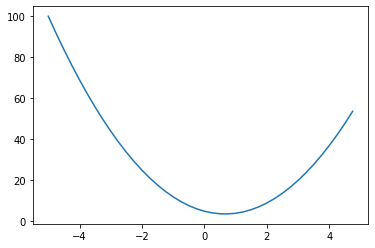

In [ ]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

>h를 임의의 작은 값으로 설정하고, $x=3$에서의 numerical gradient를 계산한다.

In [ ]:
h = 0.0001
x = 3.0
grad = (f(x+h)-f(x))/h # numerical gradient
print(grad)

14.000300000063248


>gradient의 결과값은 14로 출력된다. 실제로 $3x^2 - 4x + 5$를 미분하면 $6x-4$이므로, $x=3$인 지점에서의 gradient 값이 14가 나오는 것을 확인할 수 있다.
>
>해당 수식의 의미를 살펴보면 입력값 $x=3$이 미세하게 커질 때 출력값이 얼마나 달라지는지를 나타낸다는 것을 알 수 있다.
>
>따라서, 주어진 함수의 $x=3$에 가까운 값에서는 x가 1만큼 커지면 최종 output값은 14만큼 커진다는 것을 의미한다.




>다음으로 multi variable 함수를 정의하고 numerical gradient를 구해보자.

In [ ]:
a = 2.0
b = -3.0
c = 10.0

def g(a, b, c):
    d = a*b+c
    return d

print(g(a, b, c))

4.0


In [ ]:
grad = (g(a+h, b, c) - g(a, b, c))/h # a에 대한 numerical gradient
print(grad)

-3.000000000010772


>딥러닝 학습은 최종 output인 loss(정답값과 예측값의 차이를 수치화 시킨 scalar)를 최소화시키는 방향으로 이루어진다.
>
>첫번째 예시의 함수 $f$의 output $f(x)$를 loss value, $x$가 우리가 update할 딥러닝 모델의 weight이라고 가정해보자.
>
>$x=3$ 지점에서 $x$를 어떤 방향으로 update하면 loss function $f(x)$를 최소화 시킬 수 있을지 알아보자
>

>Gradient의 방향으로 $x$가 이동할 경우 함수의 output이 커지는 것을 확인할 수 있다.

In [ ]:
print(f(x+0.001*grad))
print(f(x+0.01*grad))
print(f(x+0.1*grad))

19.958026999999852
19.58269999999851
16.06999999998686


>Gradient의 반대 방향으로 $x$가 이동할 경우 함수의 output이 작아진다.

In [ ]:
print(f(x-0.001*grad))
print(f(x-0.01*grad))
print(f(x-0.1*grad))

20.042027000000154
20.422700000001527
24.470000000017023


>즉, 딥러닝 모델을 학습시키기 위해 딥러닝 모델의 weight을 weight에 대한 loss의 gradient의 **반대** 방향으로 update한다.
>
>이러한 gradient를 이용한 최적화 알고리즘을 gradient descent라고 부른다.

###2-2. Manual backpropagation with analytic gradient

>간단한 함수의 경우(computation graph)의 경우 미분을 이용해 numerical gradient를 쉽게 구할 수 있지만, 매우 복잡한 함수로 이루어진 딥러닝 모델의 경우 미분 연산에 매우 많은 비용이 소모된다.
>
>따라서, 현대의 딥러닝 모델의 학습은 chain rule을 이용해서 output에서 leaf node까지 gradient를 역순으로 구해나가는 *analytic gradient*를 이용한 backpropagation을 수행하고 있다.
>
>이러한 과정을 구현하며 analytic gradient를 구하는 방법을 파악해보자.

In [ ]:
# 토이 텐서인 MyTensor 구현
# gradient attribute 추가

class MyTensor:
    def __init__(self, data, _children=(), _op='', name=''):
        self.data = data
        self.grad = 0.0  # gradient가 생성시 0으로 초기화
        self._prev = set(_children) 
        self._op = _op 
        self.name = name

    def __repr__(self):
        return f"MyTensor({self.name}, data={self.data})"
    
    def __add__(self, other):
        out = MyTensor(self.data + other.data, (self, other), '+')
        return out
    
    def __mul__(self, other):
        out = MyTensor(self.data * other.data, (self, other), '*')
        return out

>위에서 사용한 graphviz 라이브러리를 이용한 compuational graph를 시각화 함수를 gradient 표시를 위해 수정했다.

In [ ]:
from graphviz import Digraph

# helper function
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

# helper function
def draw_dot(root, format='svg', rankdir='LR'):
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.name, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

#### 2-2-1. Example 1

>모든 gradient가 0으로 초기화 되어있다.

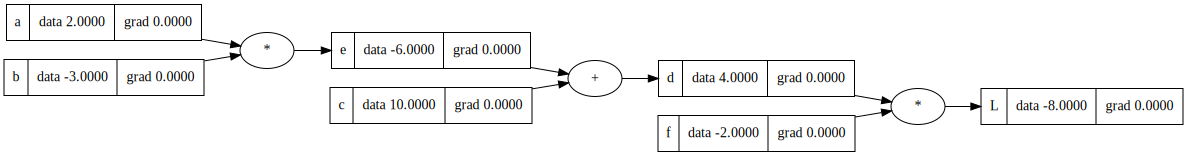

In [ ]:
a = MyTensor(2.0, name='a')
b = MyTensor(-3.0, name='b')
c = MyTensor(10.0, name='c')
e = a*b; e.name='e'
d = e+c; d.name='d'
f = MyTensor(-2.0, name='f')
L = d*f; L.name='L'

draw_dot(L)

>가장 먼저, $\dfrac{\partial L}{\partial L}$을 계산한다. 
>
>$\dfrac{\partial L}{\partial L}=1$ 이다.

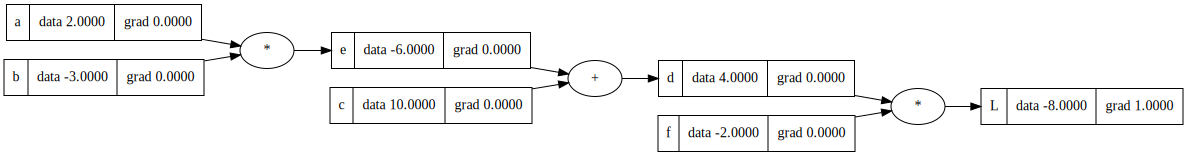

In [ ]:
L.grad = 1
draw_dot(L)

**Multiplicative gate (mul gate, swap multiplier, *)**

>다음으로, $\dfrac{\partial L}{\partial d}$를 계산한다. 
>
>$L = d*f$ 이기 떄문에, $\dfrac{\partial L}{\partial d} = f = -2$ 라는 것을 확인해 볼 수 있다.
>
>마찬가지로, $\dfrac{\partial L}{\partial f} = d = 9$ 를 손쉽게 계산할 수 있다. 
>
>곱셈은 상대 노드의 value 값을 gradient 값으로 취하기 때문에 swap multiplier로 불린다.

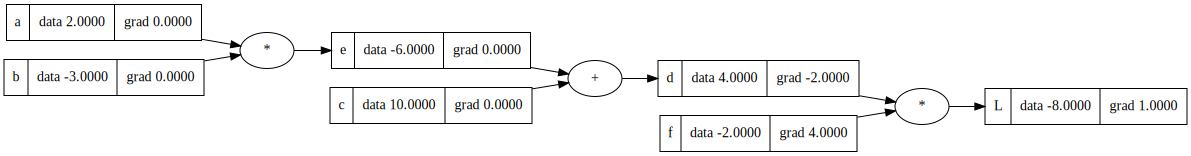

In [ ]:
d.grad = -2
f.grad = 4
draw_dot(L)

**chain rule**

>$\dfrac{\partial L}{\partial e}$를 계산해보자. 
>
>Chain rule에 의해 해당 gradient가 $\dfrac{\partial L}{\partial e} = \dfrac{\partial L}{\partial d} \dfrac{\partial d}{\partial e}$ 로 분리될 수 있고, $\dfrac{\partial L}{\partial d}$ 는 위에서 이미 값을 구했다.
>
>따라서, local gradient $\dfrac{\partial d}{\partial e}$ 의 값을 계산하면, 이를 backpropagation에 의해 계산되어 내려오는 gradient $\dfrac{\partial L}{\partial d}$와 곱하면 원하는 값을 얻을 수 있다.

**add gate (gradient distributor)**

>$d=e+c$,
>
>$\dfrac{\partial d}{\partial e} = \dfrac{\partial e}{\partial e} + \dfrac{\partial c}{\partial e} = 1$
>
>따라서 $\dfrac{\partial L}{\partial e} = \dfrac{\partial L}{\partial d} \dfrac{\partial d}{\partial e} = -2 \times 1 = -2.$
>
>마찬가지로, $\dfrac{\partial d}{\partial c} = 1$이기 때문에 $\dfrac{\partial L}{\partial c} = \dfrac{\partial L}{\partial d} \dfrac{\partial d}{\partial c} = -2 \times 1 = -2.$
>
>덧셈은 위에서 내려오는 gradient를 각 노드에 그대로 전달하는 gradient distributor의 역할을 한다.

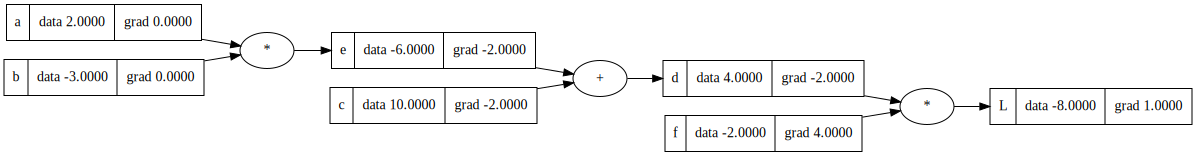

In [ ]:
e.grad = -2
c.grad = -2
draw_dot(L)

>마찬가지로, mul gate (swap multiplier)의 성질에 따라 
>
>$\dfrac{\partial L}{\partial b} = \dfrac{\partial L}{\partial e} \dfrac{\partial e}{\partial b} = -2 \times 2 = -4$
>
>$\dfrac{\partial L}{\partial a} = \dfrac{\partial L}{\partial e} \dfrac{\partial e}{\partial a} = -2 \times -3 = 6$.




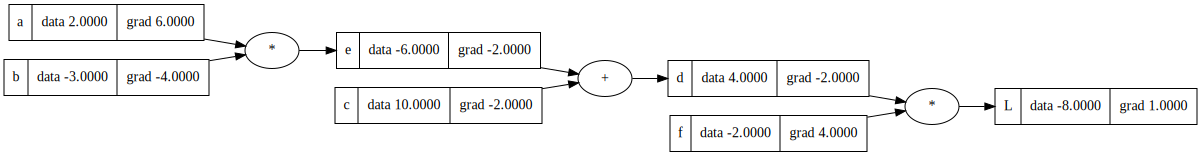

In [ ]:
b.grad = -4
a.grad = 6
draw_dot(L)

>앞서 학습한 numerical gradient를 계산해보고, 계산이 맞는지 확인해보자.
>
>$\dfrac{\partial L}{\partial a}$, $\dfrac{\partial L}{\partial b}$가 같은 값이 나오는 것을 확인할 수 있다.

In [ ]:
def func(_a,_b,_c,_f):
    a = MyTensor(_a, name='a')
    b = MyTensor(_b, name='b')
    c = MyTensor(_c, name='c')
    e = a*b; e.name='e'
    d = e+c; d.name='d'
    f = MyTensor(_f, name='f')
    L = d*f; L.name='L'
    return L.data

# a에 대한 numerical gradient (dL/da)
h = 0.0001

_a_val = 2
_b_val = -3
_c_val = 10
_f_val = -2
grad = (func(_a_val + h, _b_val, _c_val, _f_val) - func(_a_val, _b_val, _c_val, _f_val))/h
print(grad)

# b에 대한 numerical gradient (dL/db)
h = 0.0001

grad = (func(_a_val, _b_val + h, _c_val, _f_val) - func(_a_val, _b_val, _c_val, _f_val))/h
print(grad)

6.000000000021544
-4.000000000008441


#### 2-2-2. Example 2 (Neuron)

>다음과 같은 구조의 computational graph를 neuron(뉴런)이라 부르고, 1 layer MLP와 같은 구조이다.
>
>Neuron에 대해 동일하게 backpropagation을 진행해본다.
>
>Activation function은 tanh 함수를 사용한다.

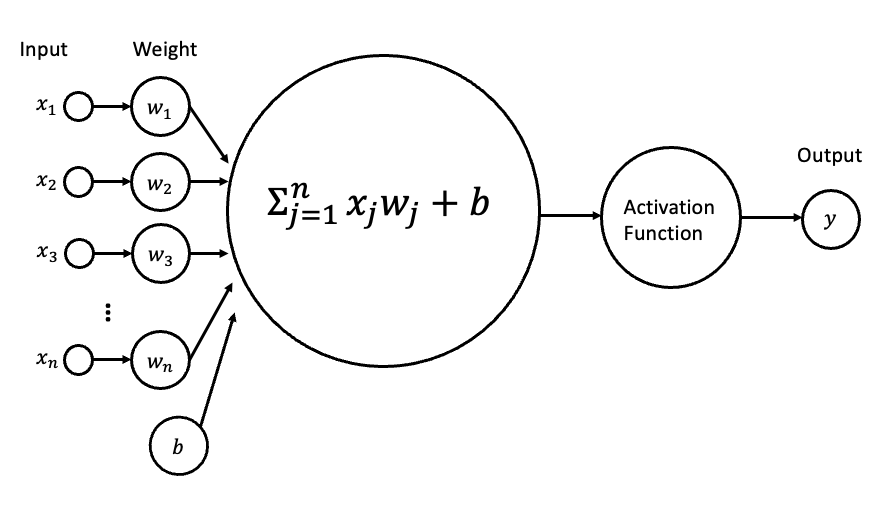

>tanh 함수는 (tanh($x$) = $\dfrac{e^x - e^{-x}}{e^x + e^{-x}}$) non linear activation function으로 input 값을 -1 ~ 1 사이의 값으로 변환시킨다.

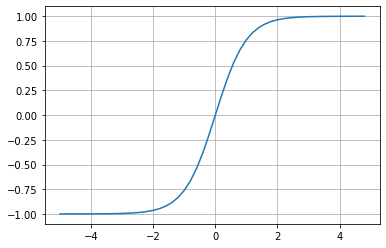

In [ ]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2)))
plt.grid()

>현재 MyTensor 구현에는 tanh 계산 방법이 없기 때문에 tanh operation을 추가한다.

In [ ]:
# 토이 텐서인 MyTensor 구현
# tanh operation 추가

class MyTensor:
    def __init__(self, data, _children=(), _op='', name=''):
        self.data = data
        self.grad = 0.0  # gradient가 생성시 0으로 초기화
        self._prev = set(_children) 
        self._op = _op 
        self.name = name

    def __repr__(self):
        return f"MyTensor({self.name}, data={self.data})"
    
    def __add__(self, other):
        out = MyTensor(self.data + other.data, (self, other), '+')
        return out
    
    def __mul__(self, other):
        out = MyTensor(self.data * other.data, (self, other), '*')
        return out

    ## tanh operation 추가
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = MyTensor(t, (self,), 'tanh')
        return out

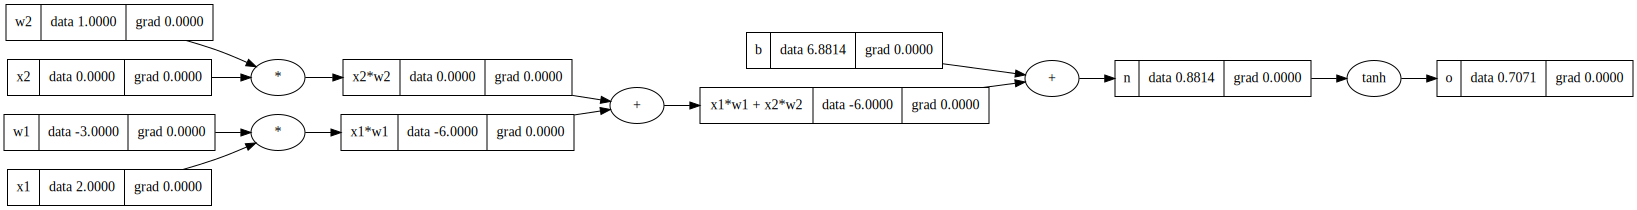

In [ ]:
x1 = MyTensor(2.0, name='x1')
x2 = MyTensor(0.0, name='x2') # inputs x1, x2 

w1 = MyTensor(-3.0, name='w1')
w2 = MyTensor(1.0, name='w2') # weights w1, w2

b = MyTensor(6.881373, name='b') # bias

x1w1 = x1*w1; x1w1.name = 'x1*w1'
x2w2 = x2*w2; x2w2.name = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.name = 'x1*w1 + x2*w2'

# x1w1 + x2w2 + b
n = x1w1x2w2 + b; n.name = 'n'

o = n.tanh(); o.name = 'o'
draw_dot(o)

>backpropagation

>$\dfrac{\partial o}{\partial o} = 1$

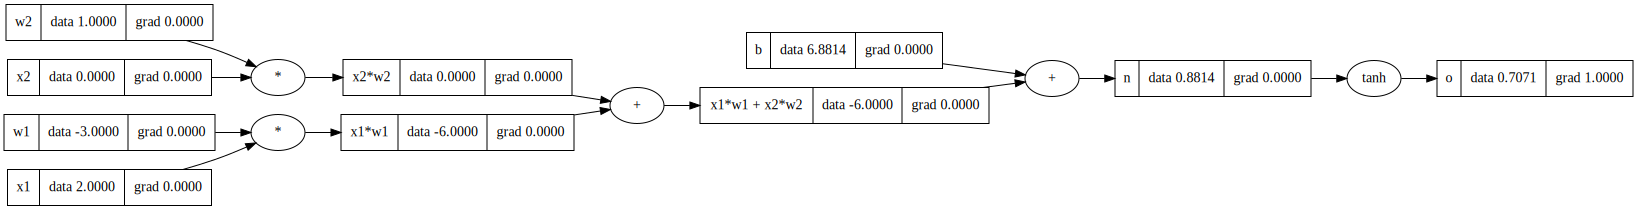

In [ ]:
o.grad = 1.0
draw_dot(o)

>$\dfrac{\partial o}{\partial n} = \dfrac{\partial \text{tanh} n}{\partial n} \dfrac{\partial o}{\partial o} = (1 - \text{tanh}^2n)\times 1 = 1 - o^2 = 1 - 0.7071^2 = 0.5$

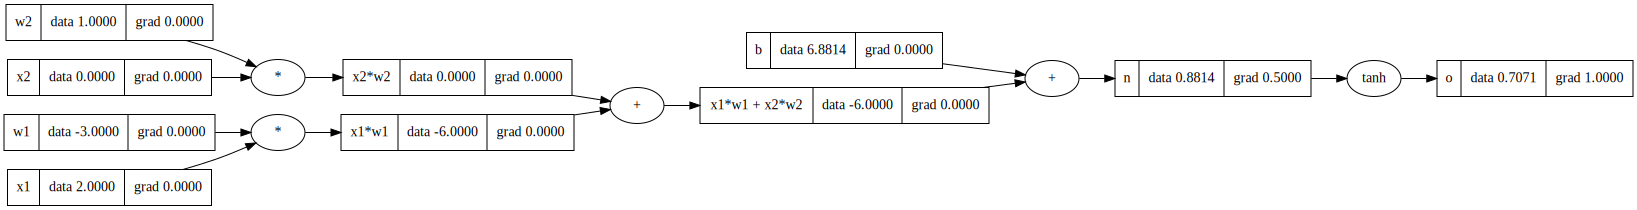

In [ ]:
n.grad = 0.5
draw_dot(o)

>add gate

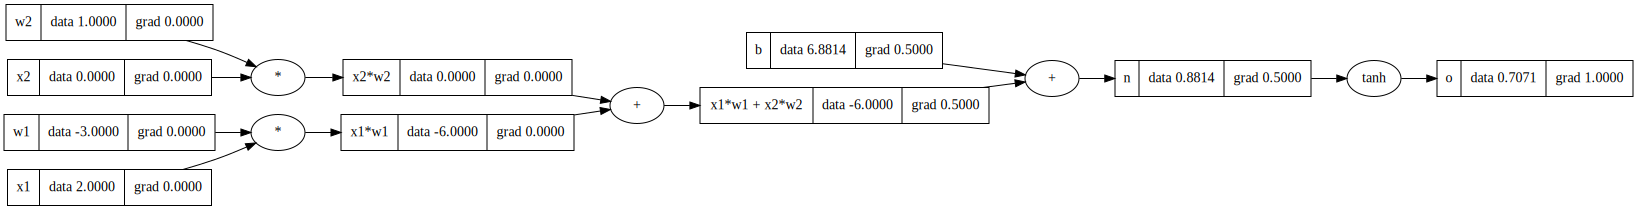

In [ ]:
x1w1x2w2.grad = 0.5
b.grad = 0.5
draw_dot(o)

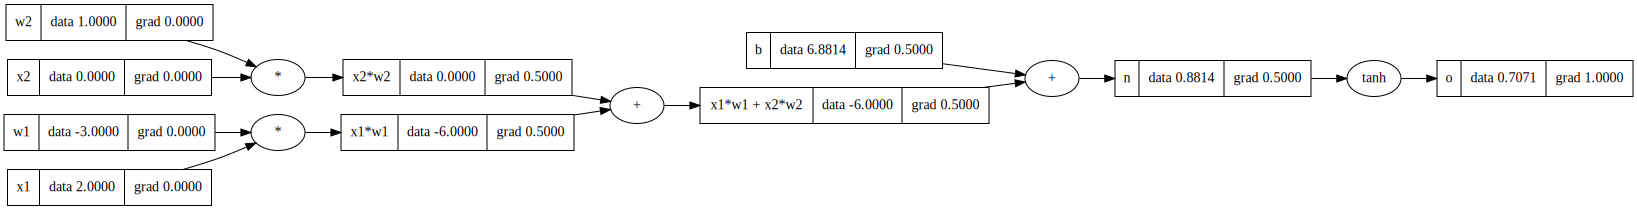

In [ ]:
x1w1.grad = 0.5
x2w2.grad = 0.5
draw_dot(o)

>mul gate

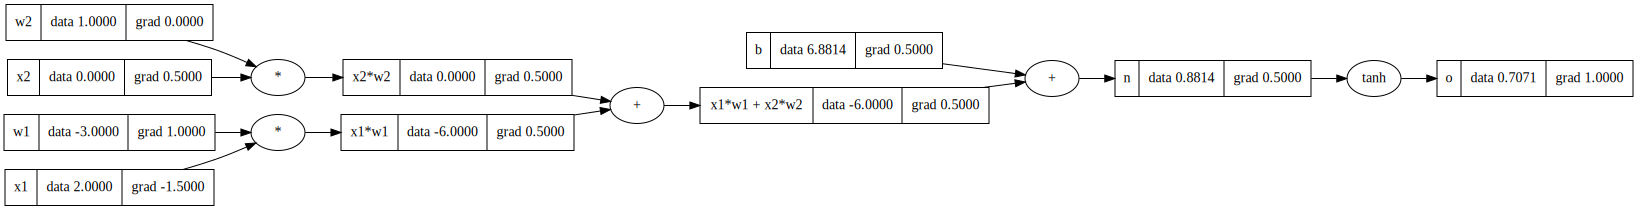

In [ ]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad
draw_dot(o)

## 3. MyTorch Autograd 구현

>PyTorch의 autograd는 backpropagation을 자동으로 수행한다.
>
>PyTorch의 autograd가 어떻게 작동하는지 원리를 이해하기 위해 사전에 정의한 MyTensor를 이용해 직접 구현해보자.

In [ ]:
# 토이 텐서인 MyTensor 구현
# _backward method 추가

class MyTensor:
    def __init__(self, data, _children=(), _op='', name=''):
        self.data = data
        self.grad = 0.0  
        self._backward = lambda: None # empty function으로 초기화
        self._prev = set(_children) 
        self._op = _op 
        self.name = name

    def __repr__(self):
        return f"MyTensor({self.name}, data={self.data})"
    
    def __add__(self, other):
        out = MyTensor(self.data + other.data, (self, other), '+')
        
        ## Add gate의 gradient distributor
        ## out의 grad 값을 self, other에 distribute
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward # out Tensor에 _backward function assign
        return out
    
    def __mul__(self, other):
        out = MyTensor(self.data * other.data, (self, other), '*')

        ## mul gate의 swap
        def _backward():
            self.grad =  other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward # out Tensor에 _backward function assign
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = MyTensor(t, (self,), 'tanh')

        ## tanh의 backward
        def _backward():
            self.grad =  (1 - t**2) * out.grad
        out._backward = _backward # out Tensor에 _backward function assign
        return out

>_backward function이 추가된 MyTensor 그래프를 다시 생성해보자.

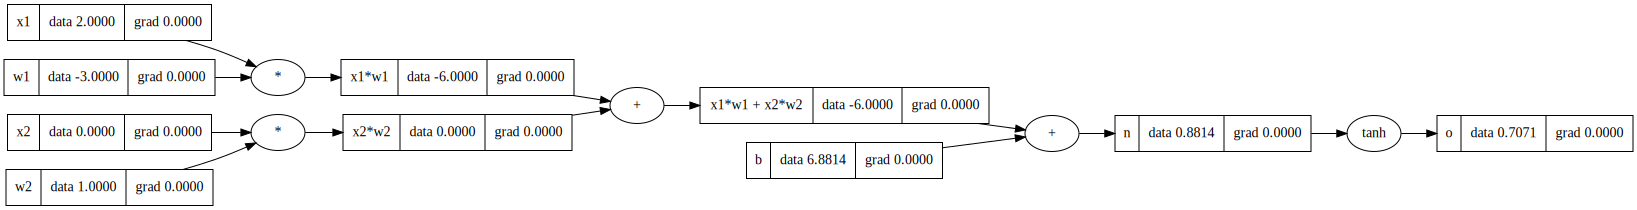

In [ ]:
x1 = MyTensor(2.0, name='x1')
x2 = MyTensor(0.0, name='x2') # inputs x1, x2 

w1 = MyTensor(-3.0, name='w1')
w2 = MyTensor(1.0, name='w2') # weights w1, w2

b = MyTensor(6.881373, name='b') # bias

x1w1 = x1*w1; x1w1.name = 'x1*w1'
x2w2 = x2*w2; x2w2.name = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.name = 'x1*w1 + x2*w2'

# x1w1 + x2w2 + b
n = x1w1x2w2 + b; n.name = 'n'

o = n.tanh(); o.name = 'o'
draw_dot(o)

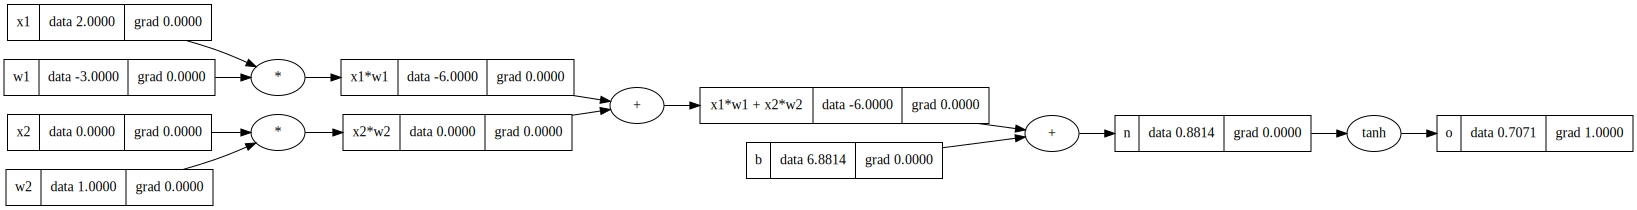

In [ ]:
o.grad = 1.0
draw_dot(o)

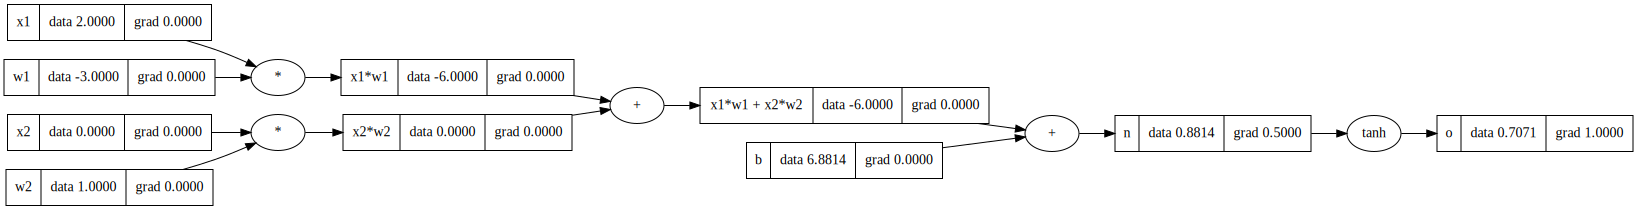

In [ ]:
o._backward()
draw_dot(o)

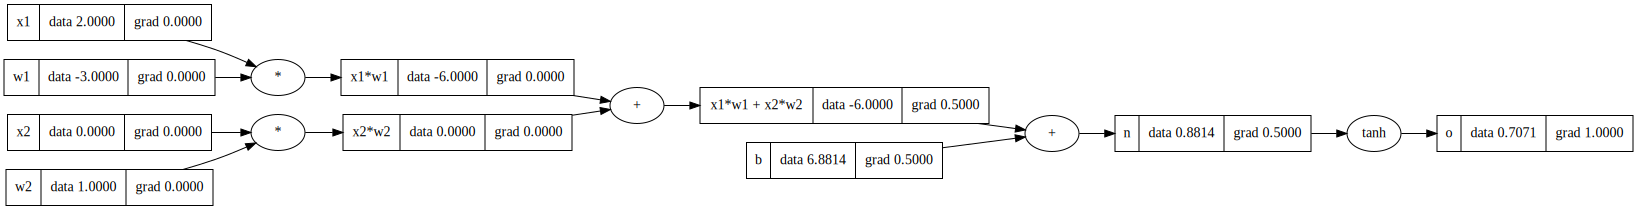

In [ ]:
n._backward()
draw_dot(o)

>b는 leaf node이기 때문에 _backward 함수가 None 이다. 

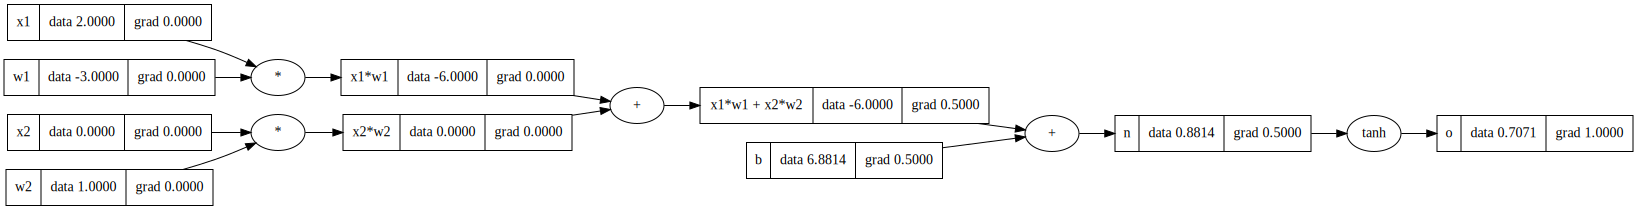

In [ ]:
b._backward()
draw_dot(o) # 변하지 않음

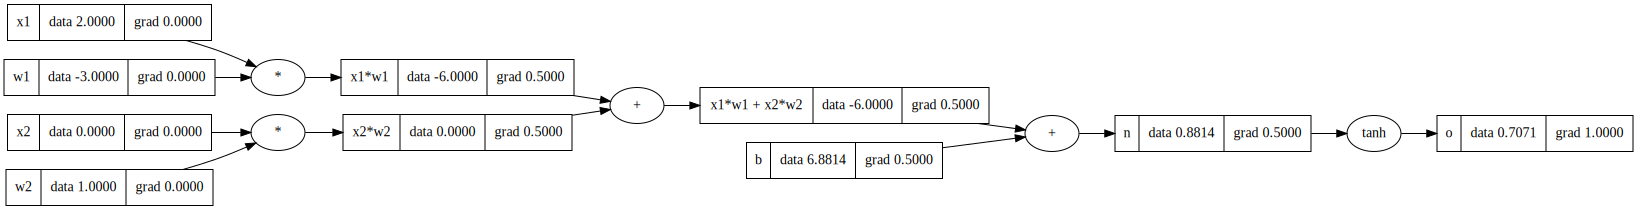

In [ ]:
x1w1x2w2._backward()
draw_dot(o)

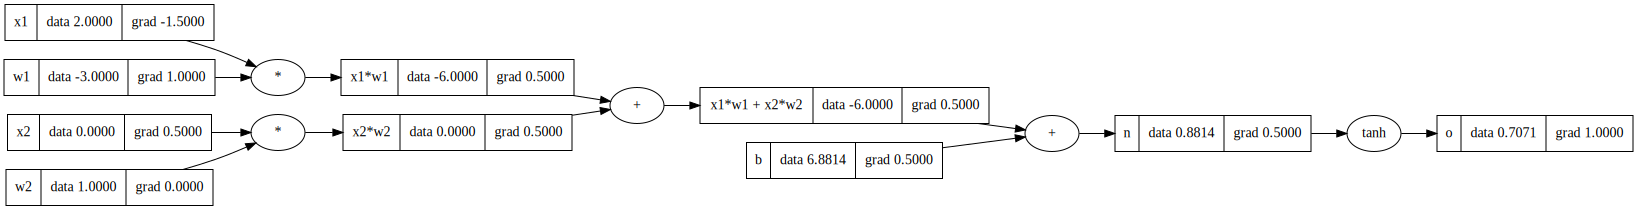

In [ ]:
x1w1._backward()
x2w2._backward()
draw_dot(o)

>마지막으로, 위의 backpropagation 과정을 최종 output node에서 단 한번의 backward 함수 실행으로 진행되도록 한다.
>
>이를 위해서, computational graph의 node 들을 순서의 역순으로 정렬한 후, 순서대로 node._backward() 함수를 호출하면 된다.
>
>node들을 순서대로 정렬한 list를 먼저 만들어보자.
>
>Recursive function을 사용해서, children node가 먼저 포함되도록 할 수 있다.

In [ ]:
topology = []
visited = set()

# Computational graph의 node를 순서대로 담고 있는 list of nodes 반환
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child) # recursive 하게 함수 실생
        topology.append(v) # parent node가 마지막에 list에 추가됨.

build_topo(o) # self node에 대해 함수 실행

for node in topology:
    print(node)

MyTensor(x1, data=2.0)
MyTensor(w1, data=-3.0)
MyTensor(x1*w1, data=-6.0)
MyTensor(x2, data=0.0)
MyTensor(w2, data=1.0)
MyTensor(x2*w2, data=0.0)
MyTensor(x1*w1 + x2*w2, data=-6.0)
MyTensor(b, data=6.881373)
MyTensor(n, data=0.881373)
MyTensor(o, data=0.7071064876766542)


>이를 역순으로 바꾸면 원하는 결과를 얻을 수 있다.

In [ ]:
for node in reversed(topology):
    print(node)

MyTensor(o, data=0.7071064876766542)
MyTensor(n, data=0.881373)
MyTensor(b, data=6.881373)
MyTensor(x1*w1 + x2*w2, data=-6.0)
MyTensor(x2*w2, data=0.0)
MyTensor(w2, data=1.0)
MyTensor(x2, data=0.0)
MyTensor(x1*w1, data=-6.0)
MyTensor(w1, data=-3.0)
MyTensor(x1, data=2.0)


>이를 바탕으로 backward 함수를 추가한다.
>
>현재 node `self`의 gradient를 구하는 것이기 때문에, 자기 자신에 대한 gradient값인 `self.grad`를 가장 먼저 1로 설정해야 한다.

In [ ]:
# 토이 텐서인 MyTensor 구현
# backward method 추가

class MyTensor:
    def __init__(self, data, _children=(), _op='', name=''):
        self.data = data
        self.grad = 0.0  
        self._backward = lambda: None 
        self._prev = set(_children) 
        self._op = _op 
        self.name = name

    def __repr__(self):
        return f"MyTensor({self.name}, data={self.data})"
    
    def __add__(self, other):
        out = MyTensor(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward 
        return out
    
    def __mul__(self, other):
        out = MyTensor(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward 
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = MyTensor(t, (self,), 'tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward
        return out

    # backward 함수 추가
    def backward(self):
        topology = []
        visited = set()

        # Computational graph의 node를 순서대로 담고 있는 list of nodes 반환
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child) # recursive 하게 함수 실생
                topology.append(v) # parent node가 마지막에 list에 추가됨.

        build_topo(self) # self node에 대해 함수 실행

        self.grad = 1.0 # self의 self 에 대한 gradient = 1
        # reversed를 통해 backpropagation이 역순으로 진행되도록
        for node in reversed(topology):
            # 각 node에 대한 _backward 함수를 역순으로 실행
            node._backward()

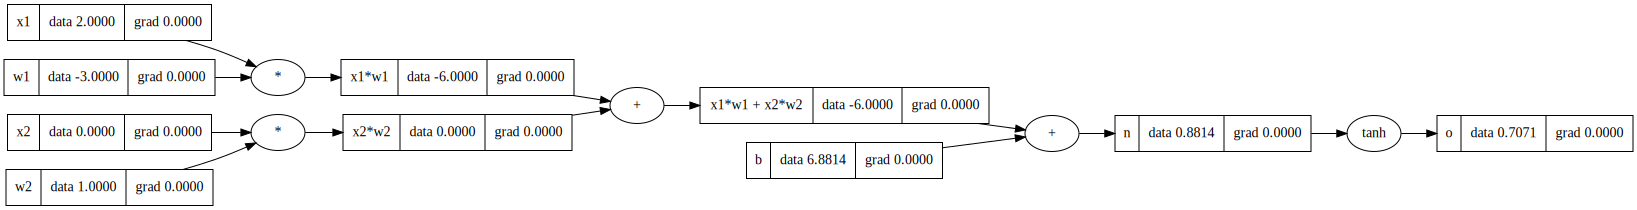

In [ ]:
x1 = MyTensor(2.0, name='x1')
x2 = MyTensor(0.0, name='x2') # inputs x1, x2 

w1 = MyTensor(-3.0, name='w1')
w2 = MyTensor(1.0, name='w2') # weights w1, w2

b = MyTensor(6.881373, name='b') # bias

x1w1 = x1*w1; x1w1.name = 'x1*w1'
x2w2 = x2*w2; x2w2.name = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.name = 'x1*w1 + x2*w2'

# x1w1 + x2w2 + b
n = x1w1x2w2 + b; n.name = 'n'

o = n.tanh(); o.name = 'o'
draw_dot(o)

>단 한번의 backward 함수 실행으로 모든 node의 gradient 값을 간편하게 계산한다.

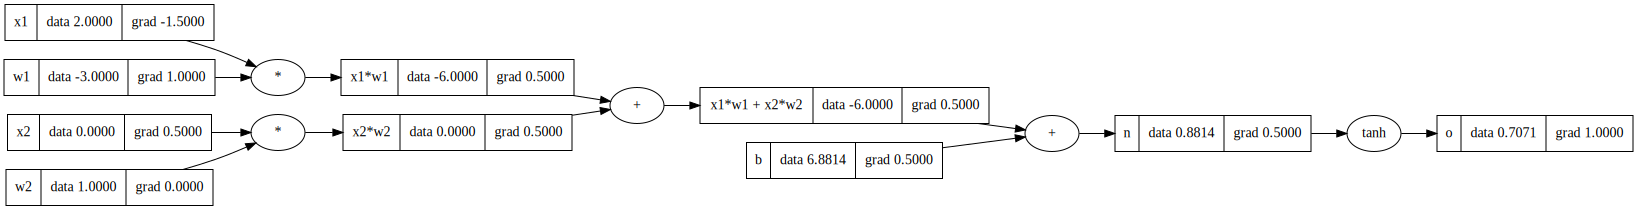

In [ ]:
o.backward() # output node에 대해 backward 함수 실행
draw_dot(o)

>하지만 PyTorch와 달리 현재 MyTensor 구현에는 한가지 문제점이 있다.

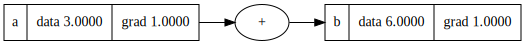

In [ ]:
a = MyTensor(3.0, name='a')
b = a + a; b.name = 'b'
b.backward()
draw_dot(b)

>$b=a+a$ 수식에서 $\dfrac{\partial b}{\partial a}=2$, 즉 grad는 2를 가져야 하지만, 1값이 나온다.
>
>MyTensor \_\_add\_\_ method의 _backward 함수를 살펴보자.
>
>같은 node 두개가 서로 더해지는 경우, _backward 함수 안에서 self와 other은 같은 object에 해당된다.
>
>이 경우 self.grad 값에 1.0\*out.grad 값이 assign된 후, 아래줄에서 다시 grad 값을 1.0\*out.grad 값으로 덮어씌운다. 

```python
    def __add__(self, other):
        out = MyTensor(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad = 1.0 * out.grad 
            other.grad = 1.0 * out.grad # self와 other이 같을 경우 값을 덮어 씌움
        out._backward = _backward 
        return out
```

>또 다른 예시를 보자.
>
>해당 computational graph에서 a와 b의 gradient가 잘못된 것을 확인할 수 있다.
>
>계산을 해보면 a.grad = -3, b.grad = -8이란 것을 알 수 있다.

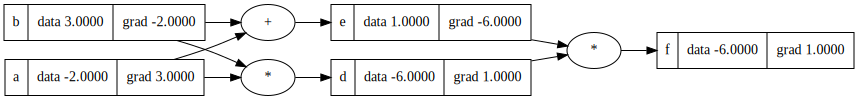

In [ ]:
a = MyTensor(-2.0, name='a')
b = MyTensor(3.0, name='b')
d = a * b; d.name='d'
e = a + b; e.name='e'
f = d * e; f.name='f'

f.backward()
draw_dot(f)

>MyTensor의 gradient 값을 한번 이상 업데이트할 경우 문제가 발생한다. 
>
>위의 _backward 함수에서 확인했듯이, gradient 값이 덮어씌워지기 때문이다.
>
>이를 방지하기 위해서, gradient값은 assignment (=) 대신 **accumulation (+=)**이 수행되어야 한다.

In [ ]:
# 토이 텐서인 MyTensor 구현

class MyTensor:
    def __init__(self, data, _children=(), _op='', name=''):
        self.data = data
        self.grad = 0.0  
        self._backward = lambda: None 
        self._prev = set(_children) 
        self._op = _op 
        self.name = name

    def __repr__(self):
        return f"MyTensor({self.name}, data={self.data})"
    
    def __add__(self, other):
        out = MyTensor(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad # = 대신 += 을 통해 gradient accumulation
            other.grad += 1.0 * out.grad # = 대신 += 을 통해 gradient accumulation
        out._backward = _backward 
        return out
    
    def __mul__(self, other):
        out = MyTensor(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad # = 대신 += 을 통해 gradient accumulation
            other.grad += self.data * out.grad # = 대신 += 을 통해 gradient accumulation
        out._backward = _backward 
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = MyTensor(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad # = 대신 += 을 통해 gradient accumulation
        out._backward = _backward
        return out

    def backward(self):
        topology = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child) 
                topology.append(v) 

        build_topo(self) 

        self.grad = 1.0 
        for node in reversed(topology):
            node._backward()

>해당 MyTensor로 computational graph를 새로 생성하고, backpropagation으로 gradient 결과를 확인해보자.
>
>알맞은 결과가 나오는 것을 확인할 수 있다.

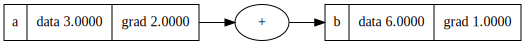

In [ ]:
a = MyTensor(3.0, name='a')
b = a + a; b.name = 'b'
b.backward()
draw_dot(b)

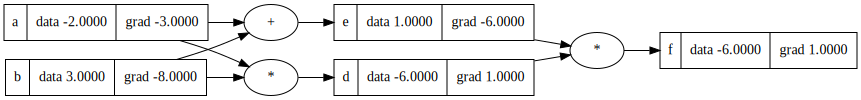

In [ ]:
a = MyTensor(-2.0, name='a')
b = MyTensor(3.0, name='b')
d = a * b; d.name='d'
e = a + b; e.name='e'
f = d * e; f.name='f'

f.backward()
draw_dot(f)

>backward() 함수를 실행할 때 마다 gradient가 누적되기 때문에, backward() 함수 호출 이후에 gradient 값을 초기화 해주어야 한다는 점을 주의해야 한다.


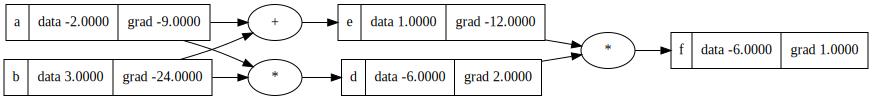

In [ ]:
f.backward() # gradient accumulation
draw_dot(f)

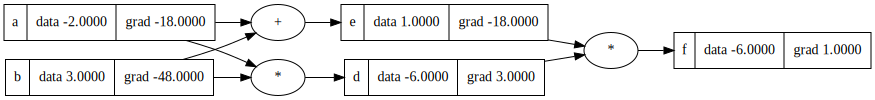

In [ ]:
f.backward() # gradient accumulation
draw_dot(f)

>PyTorch 역시 `.backward()` 함수를 호출할 때 마다 gradient가 누적되고, 따라서 다음 강의에서 학습할 `Optimizer.zero_grad()`를 통해 매 학습 iteration마다 각 노드(텐서)에 저장된 gradient값을 0으로 초기화해야 한다.

## 4. PyTorch Autograd 비교

>PyTorch는 위에서 학습한 모든 기능들을 가지고 있고, 이를 매우 편리하게 사용할 수 있도록 한다.


>`Tensor.requires_grad=True`를 통해 PyTorch Tensor가 gradient를 저장하도록 할 수 있다.
>
>일반적으로 network input에 대해서는 gradient를 계산할 필요가 없기 때문에 기본값은 False로 되어있지만, 이를 True로 바꾼 후에 autograd를 활용할 수 있다.
>
>`Tensor.grad`를 통해 해당 텐서의 gradient를 반환할 수 있다. 기본적으로 None으로 초기화 되고, backward function을 실행할 경우 해당 값을 얻을 수 있다.

>아래 셀의 결과 MyTorch 결과와 PyTorch 결과가 동일함으로 확인할 수 있다.

>텐서를 print할 경우, 해당 텐서의 data item과 type 외에 operation(grad_fn)을 확인할 수 있다.
>
>혹은 `Tensor.grad_fn`으로 직접 출력할 수 있다.

In [ ]:
print(n) # add gate
print(n.grad_fn)

tensor([0.8814], dtype=torch.float64, grad_fn=<AddBackward0>)


>MyTorch 구현과 동일하게, PyTorch에서도 leaf node(tensor)의 operation은 None인 것을 확인할 수 있다.

In [ ]:
import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.881373]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o)
print()
print('x1.grad: ', x1.grad)
print('w1.grad: ', w1.grad)
print('x2.grad: ', x2.grad)
print('w2.grad: ', w2.grad) # gradient가 none으로 초기화
print()

# backpropagation
o.backward()
print('x1.grad: ', x1.grad)
print('w1.grad: ', w1.grad)
print('x2.grad: ', x2.grad)
print('w2.grad: ', w2.grad)

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

x1.grad:  None
w1.grad:  None
x2.grad:  None
w2.grad:  None

x1.grad:  tensor([-1.5000], dtype=torch.float64)
w1.grad:  tensor([1.0000], dtype=torch.float64)
x2.grad:  tensor([0.5000], dtype=torch.float64)
w2.grad:  tensor([0.], dtype=torch.float64)


In [ ]:
print(x1)
print(x1.grad_fn)

tensor([2.], dtype=torch.float64, requires_grad=True)
None


Credits from:
- https://github.com/karpathy/micrograd